In [52]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from scipy.optimize import least_squares

In [53]:
def bresenhamLine(x0, y0, x1, y1):
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = -1 if x0 > x1 else 1
    sy = -1 if y0 > y1 else 1
    err = dx - dy

    points = []

    while True:
        points.append((x0, y0))

        if x0 == x1 and y0 == y1:
            break

        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

    return points

def calculateCoordinates(fnid_value):
    """
    提供fnid,计算格网的横纵坐标
    """
    x = fnid_value % 357
    y = fnid_value // 357
    return x, y

def fnid_from_coordinates(x, y):
    """
    根据格网的横纵坐标,计算fnid
    """
    return y * 357 + x

def odLineFnids(fnid_o, fnid_d):
    """
    计算起始点到终止点直线经过的fnid格网编号
    """
    x0, y0 = calculateCoordinates(fnid_o)
    x1, y1 = calculateCoordinates(fnid_d)

    line_points = bresenhamLine(x0, y0, x1, y1)

    fnids = [fnid_from_coordinates(x, y) for x, y in line_points]
    return fnids

In [54]:
grid=gpd.read_file('../data/shp/nanshan_value/nanshan_value.shp')
od_cluster_df = pd.read_csv('../data/od_cluster.csv')

od_cluster_df = od_cluster_df.drop_duplicates(subset=['origin_lat', 'origin_lng', 'destination_lat', 'destination_lng'])

In [55]:
gdf = gpd.read_file('../data/shp/nanshan_value/nanshan_value.shp')
gdf['id'] = range(1, len(gdf) + 1)
max_id = max(gdf['id'])
min_value = gdf['states'].min()
max_value = gdf['states'].max()
gdf['states'] = ((gdf['states'] - min_value) / (max_value - min_value)) * (2 - 0) + 0 # 归一化为0-2

In [56]:
od_cluster_df['source_geometry'] = [Point(xy) for xy in zip(od_cluster_df.origin_lng, od_cluster_df.origin_lat)]
od_cluster_df['target_geometry'] = [Point(xy) for xy in zip(od_cluster_df.destination_lng, od_cluster_df.destination_lat)]

all_residuals = []
for index,row in od_cluster_df.iterrows():
    source_point = row['source_geometry']  
    target_point = row['target_geometry']
    fnid_o = gdf[gdf.contains(source_point)]['fnid'].values[0] if gdf.contains(source_point).any() else None
    fnid_d = gdf[gdf.contains(target_point)]['fnid'].values[0] if gdf.contains(target_point).any() else None
    if not fnid_o or not fnid_d:
        continue

    fnid_list=odLineFnids(fnid_o, fnid_d)
    matched_gdf = gdf[gdf['fnid'].isin(fnid_list)]

    # N = len(matched_gdf)*1
    N = sum(matched_gdf['states'])
    omega = (row['count']) 
    C = np.log(omega)

    id_list = matched_gdf['id'].to_list()

    def total_residual_func(N, C, id_list):
        def residual(x):
            # 直接从x中选取id_list对应的值进行计算
            sum_x = np.sum(x[id_list])
            return sum_x - (N - C)
        return residual
    
    all_residuals.append(total_residual_func(N, C, id_list))

e:\Anaconda\envs\django\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [57]:
from scipy.optimize import least_squares

def total_residual(x):
    # 使用列表推导收集所有单个残差
    total_resid = [res(x) for res in all_residuals]
    # 将列表转换为一维数组
    return np.array(total_resid)

# x0 = np.ones(max_id)  
x0 = gdf.states
result = least_squares(total_residual, x0)

print("优化结果：", result.x)

优化结果： [ 0.8989441   0.76421385 -4.10300102 ...  0.68584376  0.6993633
  0.74038424]


In [58]:
gdf['ds'] = result.x

# gdf['ds']=np.log2(gdf['ds'] + abs(gdf['ds'].min()) + 1) # LOG

In [59]:
# gdf = gdf.drop('encoding', axis=1)
gdf.to_file('../data/cmap/cmap_distance.shp', driver='ESRI Shapefile', crs='EPSG:4326')

# 最小二乘回归后，对结果的检验

## 残差图

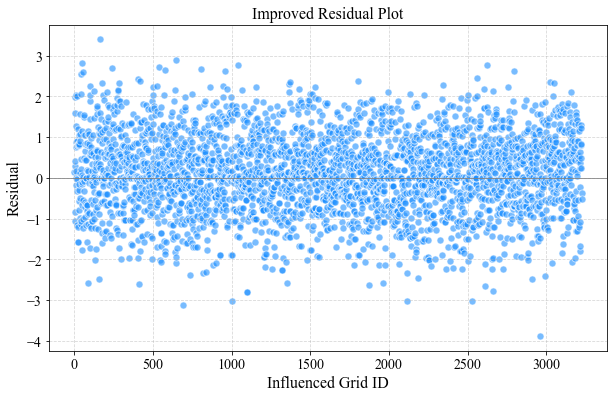

In [60]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(10, 6))
plt.scatter(range(len(result.fun)), result.fun, alpha=0.6, edgecolors='w', s=50, color='dodgerblue')
plt.title('Improved Residual Plot', fontsize=16)
plt.xlabel('Influenced Grid ID', fontsize=16)
plt.ylabel('Residual', fontsize=16)
plt.axhline(0, color='grey', linewidth=0.8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()